# Module 1

## Activity 1: simple regression problem, frequentist approach

First we generate a set of $N$ data generated from the function $y=\sin(2\pi x)$, smeared with random Gaussian noise, with variation $\sigma =0.3$. We start by generating 10 points and then progress to 100, then 1000 to see the difference between dataset sizes. These will represent our training sample $\hat{t}$, and our goal is to predict the values of this target variable for some new value of $\hat{x}$. This is equivalent to identifing the type of underlying function and some shape parameter.

In [2]:
# first import necessary packages
import numpy as np
import matplotlib.pyplot as plt

### a. Plot the datasets

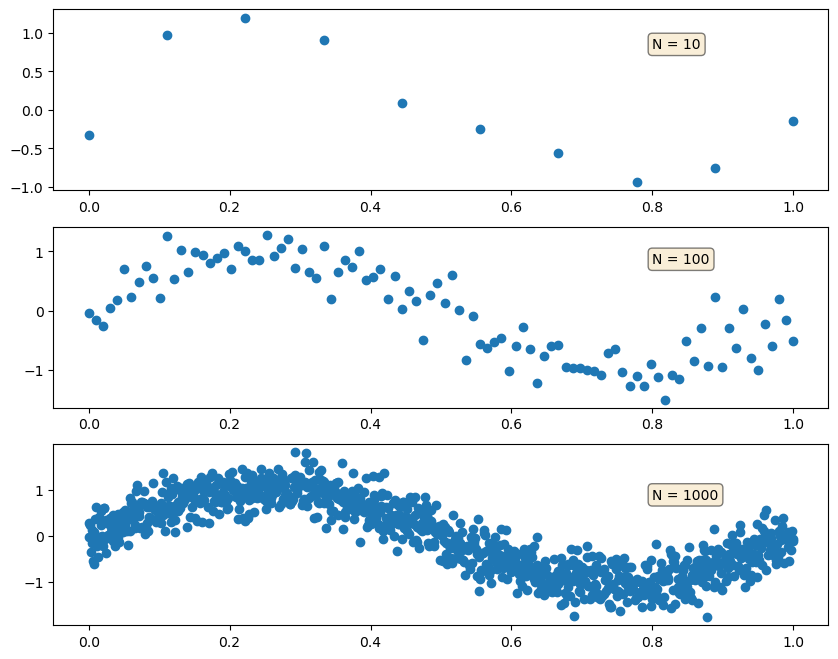

In [3]:
# creating first function to make datasets on size
def sine_set(x, A = 1, f=1, sigma=.3):
    N = np.size(x)
    noise = np.random.normal(scale=sigma, size=N)
    data = A * np.sin(2*np.pi*f*x)
    y = data + noise
    return y


# x1 = np.linspace(0, 1, 10)
# x2 = np.linspace(0, 1, 100)
# x3 = np.linspace(0, 1, 1000)
x = [np.linspace(0, 1, 10**(i+1)) for i in range(3)]
t = [sine_set(x[i]) for i in range(len(x))]
fig,  axs = plt.subplots(3, figsize = (10,8))

for i in range(3):
    axs[i].scatter(x[i], t[i])
    axs[i].text(.8, .8, f"N = {10**(i+1)}",
                bbox = dict(boxstyle='round', facecolor='wheat',
                            alpha=.5))

# ax1.scatter(x1, sine_set(x1))
# ax2.scatter(x2, sine_set(x2))
# ax3.scatter(x3, sine_set(x3))

### b. Fitting polynomials

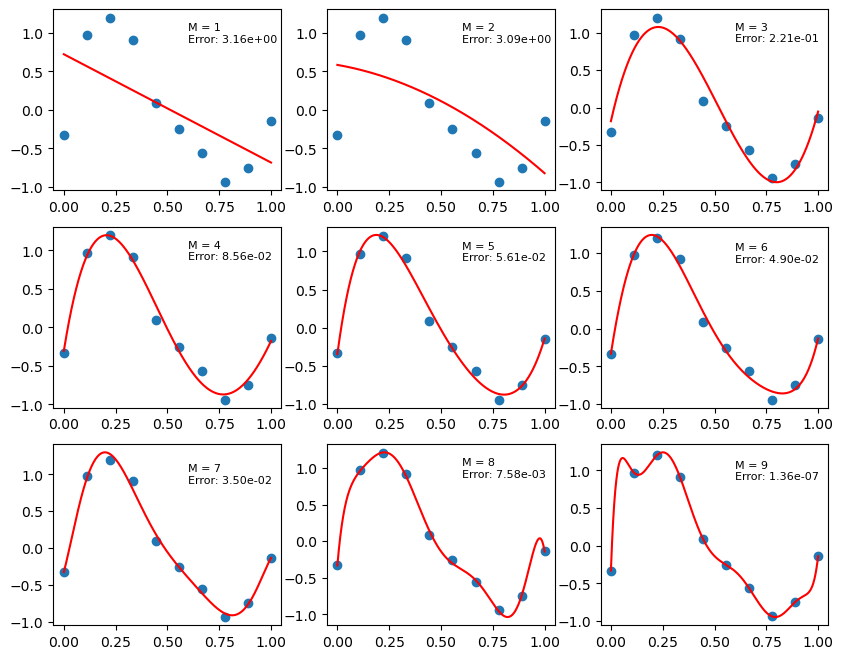

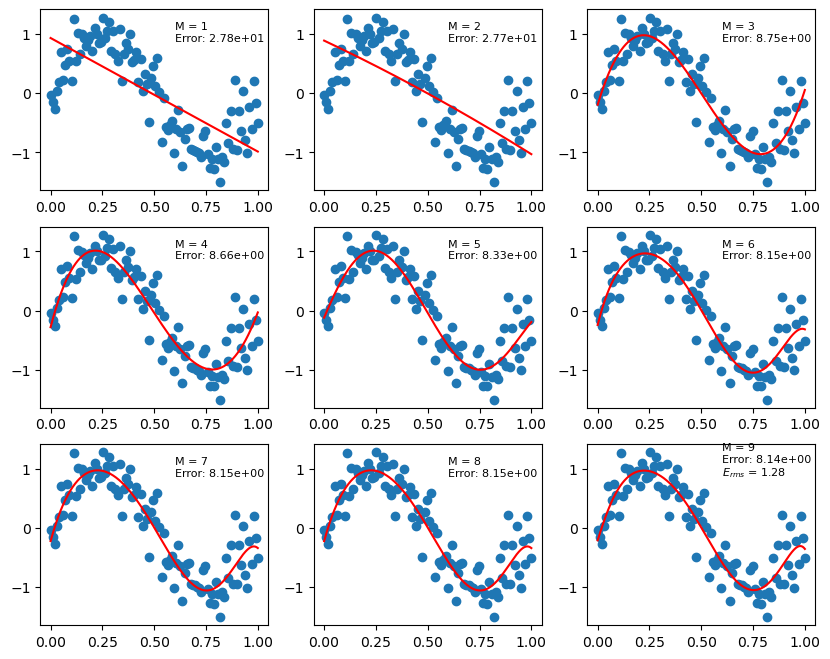

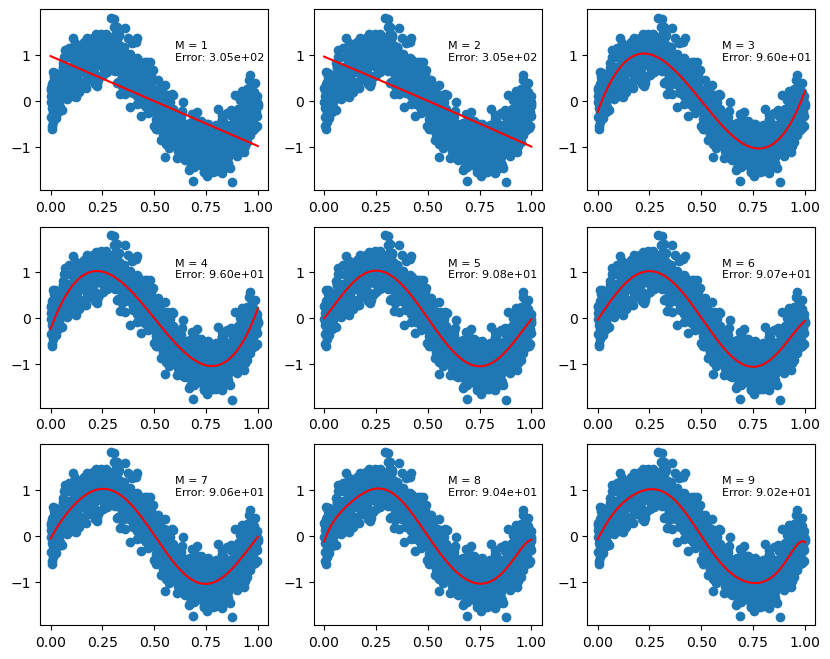

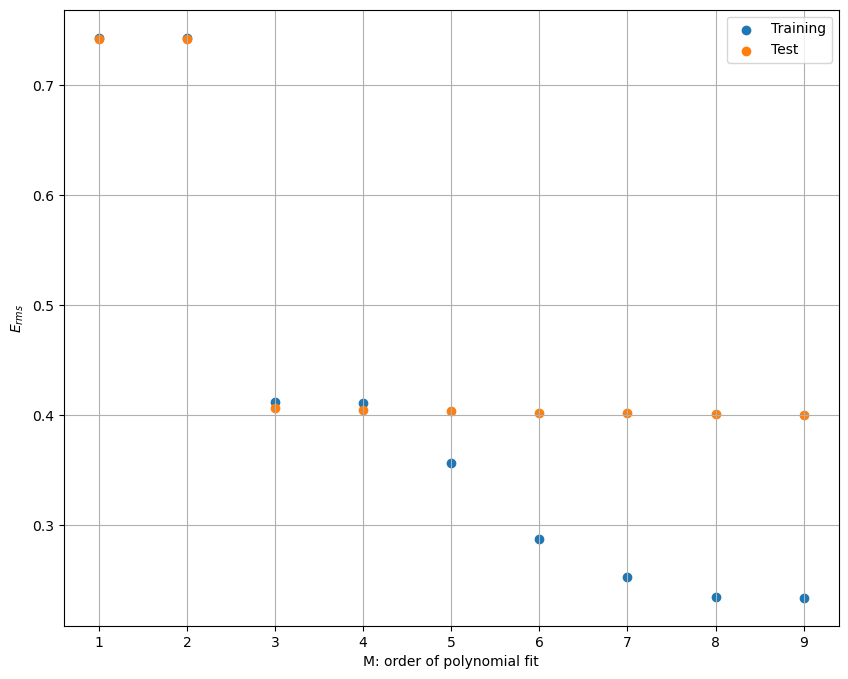

In [4]:
# polynomial fit function
def polynomial_fit(x, t, degree=1):
    if degree < 0:
        raise ValueError("Degree of polynomial must greater than or equal to 0.")
    elif x.ndim != 1:
        return ValueError("x must be one dimensional.")
    elif len(x) != len(t):
        return ValueError("x and t must be same size.")
    
    else:
        w = np.zeros(degree+1)
        A = np.zeros((len(x), degree+1))
        for i in range((len(x))):
            A[i,:] = np.array([x[i]**n for n in range(degree+1)])
        # Q, R = np.linalg.qr(A)
        # w = np.linalg.solve(R, Q.T @ t)
        w = np.linalg.inv(A.T@A)@A.T@t

        r = t - A@w
        residual = r@r
        return w, residual

def poly(x, p):
    y = np.zeros_like(x)
    for i in range(len(x)):
        y[i] = np.sum([p[j]*x[i]**j for j in range(len(p))])
    return y

def find_rms(x, t, M):
    rms = np.zeros(len(M))
    for i in range(len(M)):
        p, error = polynomial_fit(x, t, M[i])
        rms[i] = np.sqrt(2*error/len(x))
    return rms

for k in range(3):
    fig, axs = plt.subplots(3, 3, figsize=(10,8)) 

    for i in range(1, 10):
        axs[(i-1)//3, (i-1)%3].scatter(x[k], t[k])


        # [p, *info] = np.polyfit(x[k], t[k], i, full=True)
        # error = info[0]
        # if len(error) == 0:
        #     error = [0]

        p, error = polynomial_fit(x[k], t[k], i)

        xfit = np.linspace(0,1,1000)
        y = poly(xfit, p)

        axs[(i-1)//3, (i-1)%3].plot(xfit, y, color='red')
        txt = f"M = {i}\nError: {error:.2e}"
        if k == 1 and i==9:
            E_rms = np.sqrt(2*error/10**k)
            txt += "\n" + r"$E_{rms}$ = " + f"{E_rms:.2f}"
        axs[(i-1)//3, (i-1)%3].text(.6, .88, txt,
                                    fontsize=8)


# part c, divide N=100 dataset and plot rms error as function of M
M = list(range(1, 10))

training, test = [], []
for i in range(len(x[1])):
    if i%4==0:
        training.append((x[1][i], t[1][i]))
    else:
        test.append((x[1][i], t[1][i]))
training, test = np.array(training), np.array(test)

training_rms = find_rms(training[:,0], training[:,1], M)
test_rms = find_rms(test[:,0], test[:,1], M)

fig, axs = plt.subplots(1, 1, figsize=(10,8))
axs.scatter(M, training_rms, label = "Training")
axs.scatter(M, test_rms, label="Test")

axs.set_xlabel("M: order of polynomial fit")
axs.set_ylabel(r"$E_{rms}$")
axs.legend()
axs.grid(True, which='both')

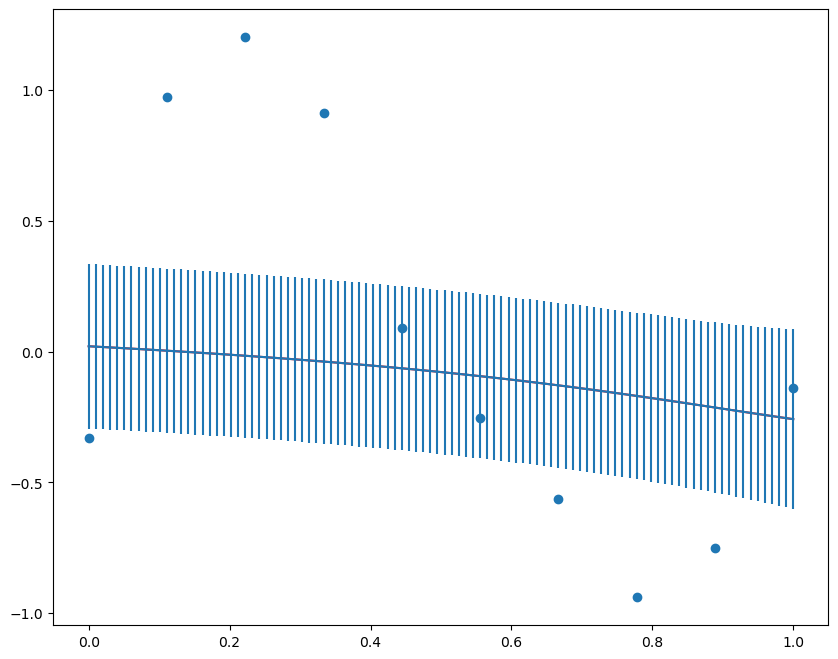

In [29]:
def pred_dist(x, xvec, tvec, M=9, alpha=5e-3, beta=11.1):
    phi_x = phi(x, M)
    # print("phi_x: ", phi_x)

    S_matrix = np.linalg.inv(Sinv(xvec, phi_x, M, alpha, beta))
    # print("S_matrix: ", S_matrix)

    m = mean(xvec, tvec, phi_x, S_matrix, beta, M)
    # print("Mean: ", m)

    var = variance(phi_x, S_matrix, beta)
    # print("Variance: ", var)

    # probability =  np.exp(-(t-m)**2/(2*var))

    return m[0,0], var[0,0]**.5

def Sinv(xvec, phi_x, M, alpha, beta):
    Sinv = alpha*np.identity(M+1)
    A = np.zeros((M+1,1))
    for i in range(len(xvec)):
        phi_n = phi(xvec[i], M) # column vector
        A += phi_n
    Sinv += beta*np.outer(A, phi_x.T)
    return Sinv

def mean(xvec, tvec, phi_x, S_matrix, beta, M):
    N = len(xvec)
    A = np.zeros((M+1,1))
    for n in range(N):
        A += phi(xvec[n], M)*tvec[n]
    B = S_matrix @ A
    m = beta*phi_x.T @ B

    return m

def variance(phi_x, S_matrix, beta):
    s2 = beta**(-1)
    s2 += phi_x.T @ S_matrix @ phi_x
    return s2

def phi(x, M):
    return np.array([x**i for i in range(M+1)]).reshape((M+1,1))


x_p5 = x[0]
t_p5 = t[0]


x_fit = np.linspace(0, 1, 100)
# x_fit = [.25]
m, sigma = [], []
for i in range(len(x_fit)):
    means, stds = pred_dist(x_fit[i], x_p5, t_p5)
    m.append(means)
    sigma.append(stds)


fig, axs = plt.subplots(1,1, figsize=(10,8))
axs.plot(x_fit, m, color='red')
axs.errorbar(x_fit, m, yerr=sigma)
axs.scatter(x_p5, t_p5)